# Main

# 조화소영 프로젝트

1. 행정동별 생활밀종업종별 매출액 데이터 수집 (2019~2022) 
   > 생활밀종업종 범주화 (1.음식점/2.교육/3.여가/4.생필품/5.의료및패션/6.서적및문구/7.가구및전자제품/8.숙박/9.전자상거래업/10.기타)


2. 데이터 전처리 (생활밀종업종별로 인코딩+상권코드별로 행정동 매칭+데이터정규화(Min-Max))
   
3. 각 연도별로 나누어서 군집화 진행 

4. 연도별로 행정동별 업종 매출 추이가 어떻게 변화했으며, 이에 따라 군집이 어떻게 달라지는 지 파악 (매출 vs 상점 수)

5. 연도별로 매출 및 군집이 달라진다면, 이것이 코로나 확진자 발생 추이와 관련이 있는 지 파악 (코로나 전인 2019년과 그 이후를 중점으로 분석하며, 급 상점 수가 감소하는 시기인 2022년을 주의깊게 볼 것)
   
6. 매출 감소가 각 상권발달에 미치는 영향은?

- 연도별 데이터 조인 + 상권코드별 행정동 매칭 + 분기당 매출 금액, 점포수만 컬럼 남기기 : 영재 
  * 점포 수: 가장 마지막 분기 데이터만 활용 : 소윤 
    * ~2021년: 4분기 
    * ~2022년: 3분기 
  * 매출금액: 분기별 매출 금액 총합 : 화정 
    * ~2021년: 1+2+3+4
    * ~2022년: 1+2+3+3

- 서비스 업종별로 나누는 함수 : 현민 

- 데이터 정규화 (min-max) : 화정 

In [1]:
# 필수라이브러리 
# matplotlib 한글 깨짐 방지

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# import PublicDataReader as pdr

fm.get_fontconfig_fonts()
font_location = '/data/notebook_files/fonts/esamanru_Medium.ttf'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
fprop = fm.FontProperties(fname=font_location)

# matplotlib.rc('font', family=font_name)

<ipython-input-1-7cb82bf20ad9>:13: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


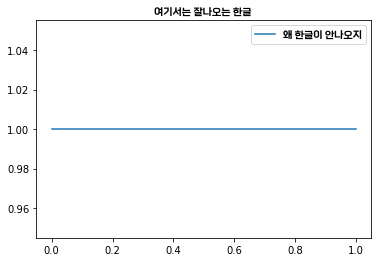

In [2]:
# 한글 깨짐 방지 예제
fig = plt.figure()
plt.plot((1, 1), label='왜 한글이 안나오지')
plt.title('여기서는 잘나오는 한글 ', fontproperties=fprop)
plt.legend(prop=fprop)
plt.show()  

## 데이터 분석 및 탐색(EDA)

In [3]:
# 서비스_업종_코드_명 분류 기준 dictionaries
classification_dicts = {"음식점":
                            ["한식음식점",
                             "중식음식점",
                             "일식음식점",
                             "양식음식점",
                             "패스트푸드점",
                             "치킨전문점",
                             "분식전문점",
                             "호프-간이주점",
                             "제과점",
                             "커피-음료", ]
    ,
                        "교육": ["일반교습학원",
                               "외국어학원",
                               "예술학원",
                               "스포츠 강습",
                               ]
    ,
                        "의료": ["일반의원",
                               "치과의원",
                               "한의원",
                               "의약품",
                               "의료기기",
                               ]
    ,
                        "여가": ["당구장",
                               "골프연습장",
                               "PC방",
                               "스포츠클럽",
                               "노래방",
                               "미용실",
                               "네일숍",
                               "피부관리실",
                               "자동차미용",
                               "운동/경기용품",
                               "자전거 및 기타운송장비",
                               ]
    ,
                        "생필품": ["슈퍼마켓",
                                "편의점",
                                "미곡판매",
                                "육류판매",
                                "수산물판매",
                                "청과상",
                                "반찬가게",
                                "세탁소",
                                "가전제품수리",
                                "자동차수리",
                                "철물점",
                                ],
                        "의류 및 패션": ["일반의류",
                                    "신발",
                                    "가방",
                                    "안경",
                                    "시계및귀금속",
                                    "화장품",
                                    ]
    ,
                        "서적 및 문구": ["서적",
                                    "문구",
                                    "완구",
                                    ]
    ,
                        "가구 및 가전제품": ["인테리어",
                                      "조명용품",
                                      "섬유제품",
                                      "화초",
                                      "가구",
                                      "가전제품",
                                      "컴퓨터및주변장치판매",
                                      "핸드폰",
                                      ]
    ,
                        "숙박": ["여관",
                               "고시원",
                               ]
    ,
                        "기타": ["부동산중개업",
                               "애완동물",
                               ]
    ,
                        "전자상거래업": ["전자상거래업"]
    ,
                        }

In [4]:
# 서비스_업종_코드_명 분류 함수
def classfy_business(string):
    global classification_dicts
    for clss,businesses in classification_dicts.items():
        if string in businesses:
            return clss
    return 'None'

## 데이터 전처리 

# EDA

In [5]:
import pandas as pd 

In [6]:
# 데이터 로드 

# 서울시 우리마을가게 상권분석서비스(상권영역)
area_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권영역).csv', encoding='cp949')

# 서울시 우리마을가게 상권분석서비스(점포) - 2020~2022
store_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-점포).csv', encoding='cp949')

# 서울시 우리마을가게 상권분석서비스(점포) - 2019
store2019_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_점포)_2019년.csv', encoding='cp949')

# 서울시 법정동, 행정동 코드정보 
seoul_df = pd.read_csv('/data/notebook_files/서울시 건축물대장 법정동,행정동 코드정보.csv', )

In [7]:
# 법정동 데이터 시군구 + 행정동 코드 결합 (추후 다른 데이터프레임과 행정동 코드를 기준으로 상권코드 가져오기 위해 진행)

seoul_df['시군구코드']= seoul_df['시군구코드'].astype(str)
seoul_df['행정동코드']= seoul_df['행정동코드'].astype(str)
seoul_df['행정동_코드'] = seoul_df['시군구코드']+seoul_df['행정동코드']
seoul_df['행정동_코드'] = seoul_df['행정동_코드'].astype(int)
hj_seoul_df = seoul_df.loc[:,['시군구명','행정동명','행정동_코드']]

In [8]:
hj_seoul_df

,시군구명,행정동명,행정동_코드
0,강남구,개포3동,11680675
1,강남구,개포3동,11680675
2,강남구,개포3동,11680675
3,강동구,상일제2동,11740526
4,강동구,상일제1동,11740525
...,...,...,...
2350,종로구,종로1.2가동,11110610
2351,종로구,종로1.2가동,11110610
2352,종로구,종로1.2가동,11110610
2353,종로구,종로1.2가동,11110610


In [9]:
hj_seoul_df['행정동_코드']=hj_seoul_df['행정동_코드'].astype(int)

In [10]:
area_df = area_df[['상권_코드','행정동_코드']]

In [11]:
area_df

,상권_코드,행정동_코드
0,2110753,11545710
1,2110427,11350611
2,2110755,11545680
3,2110739,11545690
4,2111017,11710562
...,...,...
1666,1001493,11140590
1667,1001494,11110615
1668,1001495,11710566
1669,1001496,11680580


In [12]:
# 행정동 데이터와 상권영역 데이터 병합 
area_df_inner = pd.merge(area_df, hj_seoul_df, how='inner', on='행정동_코드')

In [13]:
area_df_inner

,상권_코드,행정동_코드,시군구명,행정동명
0,2110753,11545710,금천구,시흥제5동
1,2110748,11545710,금천구,시흥제5동
2,2110754,11545710,금천구,시흥제5동
3,2130238,11545710,금천구,시흥제5동
4,2110427,11350611,노원구,하계제1동
...,...,...,...,...
3847,2130166,11380590,은평구,응암제2동
3848,2130113,11260690,중랑구,신내2동
3849,2130051,11140665,중구,동화동
3850,2130102,11230750,동대문구,이문제2동


In [14]:
area_df_inner = area_df_inner.sort_values(by='상권_코드')

In [15]:
area_df_inner

,상권_코드,행정동_코드,시군구명,행정동명
281,1001491,11170650,용산구,이태원제1동
2493,1001492,11140520,중구,소공동
2490,1001492,11140520,중구,소공동
2489,1001492,11140520,중구,소공동
2488,1001492,11140520,중구,소공동
...,...,...,...,...
451,2130322,11740620,강동구,천호제3동
1545,2130323,11740660,강동구,성내제3동
116,2130324,11740685,강동구,길동
1810,2130325,11740530,강동구,명일제1동


In [16]:
# 중복되는 코드 제거 

area_df_inner = area_df_inner.drop_duplicates()
area_df_inner

,상권_코드,행정동_코드,시군구명,행정동명
281,1001491,11170650,용산구,이태원제1동
2493,1001492,11140520,중구,소공동
3735,1001493,11140590,중구,광희동
3436,1001494,11110615,종로구,종로1.2.3.4가동
3851,1001495,11710566,송파구,오륜동
...,...,...,...,...
451,2130322,11740620,강동구,천호제3동
1545,2130323,11740660,강동구,성내제3동
116,2130324,11740685,강동구,길동
1810,2130325,11740530,강동구,명일제1동


In [17]:
# 2차적으로 중복 코드 제거 (행정동 및 코드는 동일하나, 다른 네임을 사용하여 중복되는 데이터 존재)

n_list = area_df_inner['상권_코드'].to_list()

n = 0
now =0 
for i in n_list :
    if n == 0 :
        now = i
        n+= 1
        continue
    if i == now : 
        print('duplicate : ',i)
    n += 1
    now = i

duplicate :  2110994
duplicate :  2130310


In [18]:
area_df_inner[area_df_inner['상권_코드'].eq(2130310)]

,상권_코드,행정동_코드,시군구명,행정동명
2560,2130310,11680670,강남구,개포제2동
2559,2130310,11680670,강남구,개포2동


In [19]:
area_df_inner[area_df_inner['상권_코드'].eq(2110994)]

,상권_코드,행정동_코드,시군구명,행정동명
2558,2110994,11680670,강남구,개포제2동
2557,2110994,11680670,강남구,개포2동


In [20]:
area_df_inner[area_df_inner['행정동명']=='개포제2동']

,상권_코드,행정동_코드,시군구명,행정동명
2558,2110994,11680670,강남구,개포제2동
2560,2130310,11680670,강남구,개포제2동


In [21]:
area_df = area_df_inner.drop([2558, 2560], axis=0)
area_df

,상권_코드,행정동_코드,시군구명,행정동명
281,1001491,11170650,용산구,이태원제1동
2493,1001492,11140520,중구,소공동
3735,1001493,11140590,중구,광희동
3436,1001494,11110615,종로구,종로1.2.3.4가동
3851,1001495,11710566,송파구,오륜동
...,...,...,...,...
451,2130322,11740620,강동구,천호제3동
1545,2130323,11740660,강동구,성내제3동
116,2130324,11740685,강동구,길동
1810,2130325,11740530,강동구,명일제1동


In [22]:
# 추정 매출 데이터 로드 

# 서울시 우리마을가게 상권분석서비스(상권-추정매출)_2022년 3분기 까지.csv
sales_2022_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2022년 3분기 까지.csv')

# 서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2021년.csv
sales_2021_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2021년.csv')

# 서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2020년.csv
sales_2020_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2020년.csv')

# 서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2019년.csv
sales_2019_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2019년.csv')

In [23]:
all_sales_df = sales_2022_df.append([sales_2021_df, sales_2020_df, sales_2019_df], ignore_index=True)
all_sales_df

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,9548586,2264,...,29,102,2162,225,1414,409,118,83,15,6
1,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300035,인테리어,103492276,370,...,0,370,0,0,0,0,0,370,0,4
2,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,55855797,130,...,0,0,130,0,0,130,0,0,0,6
3,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,8443170204,4794,...,0,2151,2643,0,105,388,987,1164,2150,6
4,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,576420408,8392,...,6,4326,3023,72,1757,2508,1961,650,398,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536519,2019,4,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,702775358,12583,...,343,7078,4510,115,3126,3837,2602,1107,798,6
536520,2019,4,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,9035390798,5146,...,0,2185,2749,0,105,387,1234,1445,1762,5
536521,2019,4,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,2418241704,11633,...,336,4998,5696,138,2886,3045,2122,1094,1403,8
536522,2019,4,U,관광특구,1001496,강남 마이스 관광특구,CS300035,인테리어,57290367,739,...,0,369,370,0,0,369,370,0,0,4


In [24]:
all_sales_df = all_sales_df[['기준_년_코드','기준_분기_코드','상권_코드','서비스_업종_코드_명','분기당_매출_금액','점포수']]
all_sales_df

,기준_년_코드,기준_분기_코드,상권_코드,서비스_업종_코드_명,분기당_매출_금액,점포수
0,2022,3,1001496,전자상거래업,9548586,6
1,2022,3,1001496,인테리어,103492276,4
2,2022,3,1001496,가전제품,55855797,6
3,2022,3,1001496,가구,8443170204,6
4,2022,3,1001496,화초,576420408,5
...,...,...,...,...,...,...
536519,2019,4,1001496,화초,702775358,6
536520,2019,4,1001496,가구,9035390798,5
536521,2019,4,1001496,가전제품,2418241704,8
536522,2019,4,1001496,인테리어,57290367,4


In [25]:
result_sales_df = pd.merge(all_sales_df, area_df, how='left', on='상권_코드')
result_sales_df

,기준_년_코드,기준_분기_코드,상권_코드,서비스_업종_코드_명,분기당_매출_금액,점포수,행정동_코드,시군구명,행정동명
0,2022,3,1001496,전자상거래업,9548586,6,11680580,강남구,삼성제1동
1,2022,3,1001496,인테리어,103492276,4,11680580,강남구,삼성제1동
2,2022,3,1001496,가전제품,55855797,6,11680580,강남구,삼성제1동
3,2022,3,1001496,가구,8443170204,6,11680580,강남구,삼성제1동
4,2022,3,1001496,화초,576420408,5,11680580,강남구,삼성제1동
...,...,...,...,...,...,...,...,...,...
536519,2019,4,1001496,화초,702775358,6,11680580,강남구,삼성제1동
536520,2019,4,1001496,가구,9035390798,5,11680580,강남구,삼성제1동
536521,2019,4,1001496,가전제품,2418241704,8,11680580,강남구,삼성제1동
536522,2019,4,1001496,인테리어,57290367,4,11680580,강남구,삼성제1동


In [26]:
result_sales_df[result_sales_df['행정동명']=='개포제2동']

,기준_년_코드,기준_분기_코드,상권_코드,서비스_업종_코드_명,분기당_매출_금액,점포수,행정동_코드,시군구명,행정동명


In [27]:
result_sales_df.head(100)

,기준_년_코드,기준_분기_코드,상권_코드,서비스_업종_코드_명,분기당_매출_금액,점포수,행정동_코드,시군구명,행정동명
0,2022,3,1001496,전자상거래업,9548586,6,11680580,강남구,삼성제1동
1,2022,3,1001496,인테리어,103492276,4,11680580,강남구,삼성제1동
2,2022,3,1001496,가전제품,55855797,6,11680580,강남구,삼성제1동
3,2022,3,1001496,가구,8443170204,6,11680580,강남구,삼성제1동
4,2022,3,1001496,화초,576420408,5,11680580,강남구,삼성제1동
...,...,...,...,...,...,...,...,...,...
95,2022,3,1001494,일반의류,9889500801,516,11110615,종로구,종로1.2.3.4가동
96,2022,3,1001494,반찬가게,1172045725,40,11110615,종로구,종로1.2.3.4가동
97,2022,3,1001494,청과상,920321651,10,11110615,종로구,종로1.2.3.4가동
98,2022,3,1001494,수산물판매,1572077711,12,11110615,종로구,종로1.2.3.4가동


In [28]:
# 업종 카테고리 분류 (음식점, 교육, 의료, 여가, 생필품, 의류 및 패션, 서적 및 문구, 가구 및 가전제품, 숙박, 전자상거래엄, 기타)
result_sales_df['서비스_업종_코드_명'] = result_sales_df['서비스_업종_코드_명'].apply(classfy_business)

In [29]:
result_sales_df

,기준_년_코드,기준_분기_코드,상권_코드,서비스_업종_코드_명,분기당_매출_금액,점포수,행정동_코드,시군구명,행정동명
0,2022,3,1001496,전자상거래업,9548586,6,11680580,강남구,삼성제1동
1,2022,3,1001496,가구 및 가전제품,103492276,4,11680580,강남구,삼성제1동
2,2022,3,1001496,가구 및 가전제품,55855797,6,11680580,강남구,삼성제1동
3,2022,3,1001496,가구 및 가전제품,8443170204,6,11680580,강남구,삼성제1동
4,2022,3,1001496,가구 및 가전제품,576420408,5,11680580,강남구,삼성제1동
...,...,...,...,...,...,...,...,...,...
536519,2019,4,1001496,가구 및 가전제품,702775358,6,11680580,강남구,삼성제1동
536520,2019,4,1001496,가구 및 가전제품,9035390798,5,11680580,강남구,삼성제1동
536521,2019,4,1001496,가구 및 가전제품,2418241704,8,11680580,강남구,삼성제1동
536522,2019,4,1001496,가구 및 가전제품,57290367,4,11680580,강남구,삼성제1동


In [30]:
import numpy as np
aa =result_sales_df.groupby(['기준_년_코드','시군구명','행정동명','서비스_업종_코드_명']).agg({'분기당_매출_금액':sum, })

In [31]:
result_sales_df.groupby(['기준_년_코드','시군구명','행정동명','서비스_업종_코드_명']).agg({'점포수':sum, })

점포수 
 
 
 기준_년_코드 
 시군구명 
 행정동명 
 서비스_업종_코드_명 
 
 
 
 
 
 2019 
 강남구 
 개포2동 
 가구 및 가전제품 
 16 
 
 
 교육 
 521 
 
 
 생필품 
 396 
 
 
 서적 및 문구 
 39 
 
 
 숙박 
 10 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2022 
 중랑구 
 중화제2동 
 숙박 
 ********* 
 
 
 여가 
 ****4*5*4*869***66*3**4*****14*****4*5*4*968**... 
 
 
 음식점 
 *6*7*16*67128*53*308643**2646**4*7*3933321*6*7... 
 
 
 의료 
 ***33*5******43*****43*6******53*****43*6**3**... 
 
 
 의류 및 패션 
 *3***9***1158****10*3****9***1158******33***9*... 
 
 
 
 14796 rows × 1 columns

In [32]:
result_sales_df[result_sales_df['기준_년_코드'].eq(2022) & result_sales_df['기준_분기_코드'].eq(3)]

,기준_년_코드,기준_분기_코드,상권_코드,서비스_업종_코드_명,분기당_매출_금액,점포수,행정동_코드,시군구명,행정동명
0,2022,3,1001496,전자상거래업,9548586,6,11680580,강남구,삼성제1동
1,2022,3,1001496,가구 및 가전제품,103492276,4,11680580,강남구,삼성제1동
2,2022,3,1001496,가구 및 가전제품,55855797,6,11680580,강남구,삼성제1동
3,2022,3,1001496,가구 및 가전제품,8443170204,6,11680580,강남구,삼성제1동
4,2022,3,1001496,가구 및 가전제품,576420408,5,11680580,강남구,삼성제1동
...,...,...,...,...,...,...,...,...,...
34100,2022,3,2110001,교육,30274954,3,11110560,종로구,평창동
34101,2022,3,2110001,음식점,29224289,*,11110560,종로구,평창동
34102,2022,3,2110001,음식점,7086399,*,11110560,종로구,평창동
34103,2022,3,2110001,음식점,300488984,3,11110560,종로구,평창동


In [33]:
result_sales_df['점포수'].value_counts()

3 148105
6 60317
* 32348
9 30936
2 19663
 ... 
633 1
588 1
1019 1
1349 1
726 1
Name: 점포수, Length: 1155, dtype: int64

In [34]:
result_sales_df['점포수'].replace('*', '1',inplace = True)

In [35]:
result_sales_df['점포수'] = result_sales_df['점포수'].astype(int)

In [36]:
result_sales_df.head()

,기준_년_코드,기준_분기_코드,상권_코드,서비스_업종_코드_명,분기당_매출_금액,점포수,행정동_코드,시군구명,행정동명
0,2022,3,1001496,전자상거래업,9548586,6,11680580,강남구,삼성제1동
1,2022,3,1001496,가구 및 가전제품,103492276,4,11680580,강남구,삼성제1동
2,2022,3,1001496,가구 및 가전제품,55855797,6,11680580,강남구,삼성제1동
3,2022,3,1001496,가구 및 가전제품,8443170204,6,11680580,강남구,삼성제1동
4,2022,3,1001496,가구 및 가전제품,576420408,5,11680580,강남구,삼성제1동


In [37]:
result_sales_df.isna().sum()

기준_년_코드 0
기준_분기_코드 0
상권_코드 0
서비스_업종_코드_명 0
분기당_매출_금액 0
점포수 0
행정동_코드 0
시군구명 0
행정동명 0
dtype: int64

In [38]:
bb =aa.unstack()

In [39]:
type(result_sales_df)

pandas.core.frame.DataFrame

In [40]:
result_sales_df

,기준_년_코드,기준_분기_코드,상권_코드,서비스_업종_코드_명,분기당_매출_금액,점포수,행정동_코드,시군구명,행정동명
0,2022,3,1001496,전자상거래업,9548586,6,11680580,강남구,삼성제1동
1,2022,3,1001496,가구 및 가전제품,103492276,4,11680580,강남구,삼성제1동
2,2022,3,1001496,가구 및 가전제품,55855797,6,11680580,강남구,삼성제1동
3,2022,3,1001496,가구 및 가전제품,8443170204,6,11680580,강남구,삼성제1동
4,2022,3,1001496,가구 및 가전제품,576420408,5,11680580,강남구,삼성제1동
...,...,...,...,...,...,...,...,...,...
536519,2019,4,1001496,가구 및 가전제품,702775358,6,11680580,강남구,삼성제1동
536520,2019,4,1001496,가구 및 가전제품,9035390798,5,11680580,강남구,삼성제1동
536521,2019,4,1001496,가구 및 가전제품,2418241704,8,11680580,강남구,삼성제1동
536522,2019,4,1001496,가구 및 가전제품,57290367,4,11680580,강남구,삼성제1동


In [41]:
aa =result_sales_df.groupby(['기준_년_코드', '행정동_코드','상권_코드','서비스_업종_코드_명']).agg({'분기당_매출_금액':sum})

In [42]:
aab =aa.unstack().fillna(0)

In [43]:
aab

분기당_매출_금액 
 
 
 
 
 서비스_업종_코드_명 
 가구 및 가전제품 
 교육 
 기타 
 생필품 
 서적 및 문구 
 숙박 
 여가 
 음식점 
 의료 
 의류 및 패션 
 전자상거래업 
 
 
 기준_년_코드 
 행정동_코드 
 상권_코드 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2019 
 11110515 
 2110008 
 4.456214e+08 
 3.832555e+08 
 0.0 
 1.312428e+10 
 1.036654e+08 
 166996509.0 
 7.760108e+08 
 1.125582e+10 
 4.667221e+08 
 8.167748e+08 
 2.356130e+09 
 
 
 2110011 
 0.000000e+00 
 0.000000e+00 
 0.0 
 0.000000e+00 
 0.000000e+00 
 0.0 
 0.000000e+00 
 1.676150e+08 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 2110014 
 0.000000e+00 
 0.000000e+00 
 0.0 
 0.000000e+00 
 2.143717e+07 
 0.0 
 2.404056e+08 
 1.650478e+09 
 0.000000e+00 
 2.000000e+06 
 0.000000e+00 
 
 
 2110015 
 0.000000e+00 
 0.000000e+00 
 0.0 
 0.000000e+00 
 0.000000e+00 
 0.0 
 0.000000e+00 
 2.910551e+09 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 2130001 
 4.543982e+08 
 1.204708e+08 
 0.0 
 1.011177e+10 
 4.053000e+09 
 0.0 
 9.754630e+07 
 3.831897e+09 
 3.945177e+08 
 5.186727e+08 
 0.000000e+00 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2022 
 11740700 
 2111073 
 1.153412e+09 
 4.076211e+08 
 230150443.0 
 7.786442e+09 
 1.533426e+07 
 34272323.0 
 3.596593e+09 
 9.436472e+09 
 1.487176e+09 
 1.156560e+09 
 0.000000e+00 
 
 
 2111076 
 0.000000e+00 
 2.219025e+09 
 0.0 
 1.430270e+09 
 2.378242e+08 
 0.0 
 1.316511e+10 
 5.696665e+09 
 2.082179e+09 
 6.229532e+08 
 0.000000e+00 
 
 
 2111079 
 0.000000e+00 
 5.722631e+08 
 0.0 
 6.827929e+08 
 3.683133e+07 
 0.0 
 1.287474e+08 
 5.226998e+08 
 1.215524e+10 
 9.741139e+07 
 0.000000e+00 
 
 
 2111081 
 0.000000e+00 
 0.000000e+00 
 746848309.0 
 0.000000e+00 
 2.422495e+08 
 0.0 
 1.141780e+08 
 4.042314e+07 
 5.931325e+08 
 8.912606e+08 
 0.000000e+00 
 
 
 2111082 
 0.000000e+00 
 2.995948e+08 
 0.0 
 5.572472e+08 
 0.000000e+00 
 0.0 
 1.894782e+08 
 3.087141e+07 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 
 
 
 6603 rows × 11 columns

In [44]:
aab.loc[(2019,11110615)]

분기당_매출_금액 
 
 
 서비스_업종_코드_명 
 가구 및 가전제품 
 교육 
 기타 
 생필품 
 서적 및 문구 
 숙박 
 여가 
 음식점 
 의료 
 의류 및 패션 
 전자상거래업 
 
 
 상권_코드 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1001494 
 1.181736e+11 
 2.201899e+10 
 3.999848e+09 
 4.320367e+10 
 1.018969e+11 
 1.173135e+10 
 4.727487e+10 
 2.889174e+11 
 9.388441e+10 
 1.071275e+11 
 4.796049e+09 
 
 
 2110019 
 1.456608e+07 
 0.000000e+00 
 0.000000e+00 
 2.410780e+09 
 0.000000e+00 
 4.206762e+07 
 0.000000e+00 
 2.139014e+09 
 1.155623e+09 
 2.005513e+09 
 4.901587e+08 
 
 
 2120004 
 3.389167e+09 
 2.155744e+08 
 0.000000e+00 
 7.025693e+09 
 6.262283e+08 
 5.128003e+07 
 1.778219e+08 
 5.330963e+10 
 6.414474e+09 
 8.107892e+09 
 1.847117e+08 
 
 
 2120006 
 4.864142e+09 
 1.955454e+10 
 0.000000e+00 
 2.736976e+10 
 9.136548e+10 
 2.080295e+09 
 1.633752e+10 
 2.980782e+11 
 6.699271e+10 
 4.448109e+10 
 1.096916e+10 
 
 
 2120008 
 4.970569e+09 
 8.637133e+08 
 0.000000e+00 
 1.890526e+10 
 1.175721e+10 
 3.617255e+08 
 6.899933e+08 
 8.276777e+10 
 8.949584e+09 
 2.240998e+10 
 1.732791e+09 
 
 
 2120009 
 3.540269e+10 
 6.307524e+09 
 0.000000e+00 
 4.109956e+10 
 6.792852e+09 
 1.550354e+10 
 6.098482e+09 
 1.876955e+11 
 4.590535e+10 
 3.453551e+11 
 1.240727e+10 
 
 
 2120010 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 6.130780e+09 
 7.188421e+06 
 2.435096e+09 
 0.000000e+00 
 7.801685e+09 
 2.501617e+10 
 4.807504e+08 
 5.101242e+08 
 
 
 2120011 
 7.493618e+08 
 0.000000e+00 
 0.000000e+00 
 9.408585e+09 
 5.370391e+09 
 0.000000e+00 
 2.297769e+09 
 1.692921e+10 
 7.857683e+09 
 4.952532e+10 
 1.571621e+08 
 
 
 2130004 
 9.389566e+09 
 0.000000e+00 
 0.000000e+00 
 3.500499e+09 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 4.937285e+08 
 0.000000e+00 
 2.604440e+07 
 0.000000e+00 
 
 
 2130005 
 1.347071e+10 
 0.000000e+00 
 0.000000e+00 
 2.065784e+08 
 3.439489e+06 
 0.000000e+00 
 0.000000e+00 
 4.107928e+07 
 0.000000e+00 
 4.403118e+08 
 1.309804e+08 
 
 
 2130006 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 0.000000e+00 
 7.319845e+07 
 0.000000e+00 
 
 
 2130007 
 1.100860e+10 
 0.000000e+00 
 2.511344e+07 
 6.483137e+09 
 7.318208e+07 
 3.605426e+08 
 5.341156e+07 
 3.244990e+10 
 2.165724e+10 
 3.949321e+09 
 0.000000e+00

In [45]:
aab.loc[(2019,1101053)]

KeyError: KeyError: 1101053

In [ ]:
def store_cnt(df):
    df[df['기준_년_코드']<2022]
    store_cnt_df = df[df['기준_분기_코드']==4]
    return store_cnt_df
    
def store_cnt_2022(df):
    df[df['기준_년_코드']==2022]
    store_cnt_2022_df = df[df['기준_분기_코드']==3]
    return store_cnt_2022_df

In [ ]:
store_cnt_df = store_cnt(result_sales_df)

In [ ]:
store_cnt_2022_df = store_cnt_2022(result_sales_df)

In [ ]:
store_cnt_2022_df.head()

In [ ]:
store_cnt_df = store_cnt_df.append(store_cnt_2022_df,ignore_index=True)

In [ ]:
store_cnt_df.drop(['기준_분기_코드', '분기당_매출_금액', '시군구명', '행정동명'], axis=1, inplace=True)

In [ ]:
store_cnt_df.head(50)

In [ ]:
store_cnt_dfgroupby(['기준_년_코드', '행정동_코드', '서비스_업종_코드_명'])['점포수'].sum()

In [ ]:
seoul_store_df = pd.DataFrame(store_cnt_df.groupby(['기준_년_코드', '행정동_코드', '서비스_업종_코드_명'])['점포수'].sum().reset_index())

In [ ]:
seoul_store_df

* 기준_분기_코드, 시군구명, 행정동명, 분기별 매출 drop 필요 
* 서비스_업종_코드_명 기준으로 groupby 
>> 해결 ! 

In [ ]:
# 연도별 업종별 총 매출액 
def quartely_sales(df):
    sales_2022_df = df.loc[df['기준_년_코드']==2022] 
    q3_df = sales_2022_df.loc[sales_2022_df['기준_분기_코드']==3]
    df = df.append(q3_df, ignore_index=True)

    total_sales_df = pd.DataFrame(df.groupby(['기준_년_코드', '행정동_코드', '서비스_업종_코드_명'])['분기당_매출_금액'].sum().reset_index())
    return total_sales_df

In [ ]:
# test2022_df = result_sales_df1.loc[result_sales_df1['기준_년_코드']==2022] 
# q3_df = test2022_df.loc[test2022_df['기준_분기_코드']==3]
# df = df.append(q3_df, ignore_index=True)

In [ ]:
seoul_sales_df = quartely_sales(result_sales_df)

In [ ]:
seoul_sales_df

In [ ]:
# 연도별 분리
store19 = seoul_store_df[seoul_store_df['기준_년_코드']==2019]
store20 = seoul_store_df[seoul_store_df['기준_년_코드']==2020]
store21 = seoul_store_df[seoul_store_df['기준_년_코드']==2021]
store22 = seoul_store_df[seoul_store_df['기준_년_코드']==2022]
        
store19_sales = seoul_sales_df[seoul_sales_df['기준_년_코드']==2019]
store20_sales = seoul_sales_df[seoul_sales_df['기준_년_코드']==2020]
store21_sales = seoul_sales_df[seoul_sales_df['기준_년_코드']==2021]
store22_sales = seoul_sales_df[seoul_sales_df['기준_년_코드']==2022]

In [ ]:
# 서비스 업종코드별 groupby 함수 

def store_cnt_fc(df):
    return df.groupby(['행정동_코드', '서비스_업종_코드_명'])['점포수'].sum().unstack()

def store_sales_fc(df):
    return df.groupby(['행정동_코드', '서비스_업종_코드_명'])['분기당_매출_금액'].sum().unstack()

In [ ]:
store19_df = store_cnt_fc(store19)
store20_df = store_cnt_fc(store20)
store21_df = store_cnt_fc(store21)
store22_df = store_cnt_fc(store22)

store19_sales_df = store_sales_fc(store19_sales)
store20_sales_df = store_sales_fc(store20_sales)
store21_sales_df = store_sales_fc(store21_sales)
store22_sales_df = store_sales_fc(store22_sales)

In [ ]:
store19_df = store19_df.fillna(1)
store20_df = store20_df.fillna(1)
store21_df = store21_df.fillna(1)
store22_df = store22_df.fillna(1)

store19_sales_df = store19_sales_df.fillna(1)
store20_sales_df = store20_sales_df.fillna(1)
store21_sales_df = store21_sales_df.fillna(1)
store22_sales_df = store22_sales_df.fillna(1)

In [ ]:
# 각 데이터프레임 csv 파일로 저장 
store19_df.to_csv('store19', index=True)
store20_df.to_csv('store20', index=True)
store21_df.to_csv('store21', index=True)
store22_df.to_csv('store22', index=True)

store19_sales_df.to_csv('store19_sales', index=True)
store20_sales_df.to_csv('store20_sales', index=True)
store21_sales_df.to_csv('store21_sales', index=True)
store22_sales_df.to_csv('store22_sales', index=True)

In [ ]:
seoul_ss_2019 = seoul_store_sales[seoul_store_sales['기준_년_코드']==2019]

In [ ]:
seoul_ss_2019.groupby(['행정동_코드', '서비스_업종_코드_명'])['분기당_매출_금액'].sum().unstack()

In [ ]:
# def sum_business_sale_total(df,service_name):
#     df[df['서비스_업종_코드_명'].eq(service_name)]


In [ ]:
seoul_store_sales

In [ ]:
seoul_store_sales2019 =seoul_store_sales[seoul_store_sales['기준_년_코드']==2019].drop('기준_년_코드' , axis=1)

In [ ]:
seoul_store_sales2019.groupby(['행정동_코드', '서비스_업종_코드_명']).max().unstack()

# 군집화 

# Hyeonmin 

In [ ]:
area_df

In [ ]:
seoul_df = pd.read_csv('/data/notebook_files/서울시 건축물대장 법정동,행정동 코드정보.csv', )

In [ ]:
store2019_df

In [ ]:
seoul_df.info()

In [ ]:
seoul_df['시군구코드'] = seoul_df['시군구코드'].astype(str)
seoul_df['행정동코드'] = seoul_df['행정동코드'].astype(str)

In [ ]:
seoul_df['시군구_행정동'] = seoul_df['시군구코드'] + seoul_df['행정동코드']

In [ ]:
seoul_df.head(3)

In [ ]:
new_seoul_df = seoul_df[['시군구명', '행정동명', '시군구_행정동']]
new_seoul_df['군구_행정동명'] = new_seoul_df['시군구명'] + ' ' + new_seoul_df['행정동명']
new_seoul_df['군구_행정동명']
new_seoul_df

In [ ]:
# 시군구 행정동 

def to_dong(area_code):
    global new_seoul_df
    area_code = str(area_code)
    temp = new_seoul_df[new_seoul_df['시군구_행정동'] == area_code]
    # print(temp, '\n',len(temp))
    # if len(temp)> 1:
    #     # print(temp)
    #     temp = temp.iloc[0]
    # return temp
    return temp['군구_행정동명'].to_list()[0]

In [ ]:
area_df['시군구_행정동'] = area_df['행정동_코드'].apply(to_dong)

In [ ]:
area_df[area_df['시군구_행정동'].str.contains('관악구')]

In [ ]:
!area_df

In [ ]:
a = area_df.groupby('시군구_행정동').agg({'상권_구분_코드_명': np.count_nonzero}).sort_values(by='상권_구분_코드_명', ascending=False)

In [ ]:
group2 = store_df.groupby(by=['기준_년_코드', '서비스_업종_번호'])['점포_수']
pd.DataFrame(group2.size().reset_index(name="Group_Count"))

In [ ]:
store_df.groupby(by=['기준_년_코드', '서비스_업종_번호'])

In [ ]:
classification_dicts = {"음식점":
                            ["한식음식점",
                             "중식음식점",
                             "일식음식점",
                             "양식음식점",
                             "패스트푸드점",
                             "치킨전문점",
                             "분식전문점",
                             "호프-간이주점",
                             "제과점",
                             "커피-음료", ]
    ,
                        "교육": ["일반교습학원",
                               "외국어학원",
                               "예술학원",
                               "스포츠 강습",
                               ]
    ,
                        "의료": ["일반의원",
                               "치과의원",
                               "한의원",
                               "의약품",
                               "의료기기",
                               ]
    ,
                        "여가": ["당구장",
                               "골프연습장",
                               "PC방",
                               "스포츠클럽",
                               "노래방",
                               "미용실",
                               "네일숍",
                               "피부관리실",
                               "자동차미용",
                               "운동/경기용품",
                               "자전거 및 기타운송장비",
                               ]
    ,
                        "생필품": ["슈퍼마켓",
                                "편의점",
                                "미곡판매",
                                "육류판매",
                                "수산물판매",
                                "청과상",
                                "반찬가게",
                                "세탁소",
                                "가전제품수리",
                                "자동차수리",
                                "철물점",
                                ],
                        "의류 및 패션": ["일반의류",
                                    "신발",
                                    "가방",
                                    "안경",
                                    "시계및귀금속",
                                    "화장품",
                                    ]
    ,
                        "서적 및 문구": ["서적",
                                    "문구",
                                    "완구",
                                    ]
    ,
                        "가구 및 가전제품": ["인테리어",
                                      "조명용품",
                                      "섬유제품",
                                      "화초",
                                      "가구",
                                      "가전제품",
                                      "컴퓨터및주변장치판매",
                                      "핸드폰",
                                      ]
    ,
                        "숙박": ["여관",
                               "고시원",
                               ]
    ,
                        "기타": ["부동산중개업",
                               "애완동물",
                               ]
    ,
                        "전자상거래업": ["전자상거래업"]
    ,
                        }

In [ ]:
def classfy_business(string):
    global classification_dicts
    for clss,businesses in classification_dicts.items():
        if string in businesses:
            return clss
    return 'None'

In [ ]:
classfy_business("인테리어")

In [ ]:
store_df['서비스_업종_코드_명'].apply(classfy_business)

In [ ]:
store_df['서비스_업종_코드_명'].value_counts()

In [ ]:
sales_df_2019

In [ ]:
sales_df_2019 = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2019년.csv')
sales_df_2020 = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2020년.csv')
sales_df_2021 = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2021년.csv')
sales_df_2022 = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2022년 3분기 까지.csv')

In [ ]:
new_code = sales_df_2019['서비스_업종_코드_명']


In [ ]:
new_code = pd.concat([new_code,sales_df_2020['서비스_업종_코드_명']])
new_code = pd.concat([new_code,sales_df_2021['서비스_업종_코드_명']])
new_code = pd.concat([new_code,sales_df_2022['서비스_업종_코드_명']])

In [ ]:
sales_df_2019['서비스_업종_코드_명'] = sales_df_2019['서비스_업종_코드_명'].apply(classfy_business)

In [ ]:
sales_df_2019.groupby('서비스_업종_코드_명').agg({'분기당_매출_금액':sum})

# Sheet 7

In [ ]:
import pandas as pd

In [ ]:
# 서울시 우리마을가게 상권분석서비스(상권영역)
area_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권영역).csv', encoding='cp949')

# 서울시 우리마을가게 상권분석서비스(점포) - 2020~2022
store_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-점포).csv', encoding='cp949')

# 서울시 우리마을가게 상권분석서비스(점포) - 2019
seoul_df = pd.read_csv('/data/notebook_files/서울시 건축물대장 법정동,행정동 코드정보.csv', )
store2019_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_점포)_2019년.csv', encoding='cp949')

In [ ]:
seoul_df.head()

In [ ]:
seoul_df['시군구코드'] = seoul_df['시군구코드'].astype(str)
seoul_df['행정동코드'] = seoul_df['행정동코드'].astype(str)

In [ ]:
seoul_df['시군구_행정동'] = seoul_df['시군구코드'] + seoul_df['행정동코드']

In [ ]:
seoul_df.head()

In [ ]:
store_df.info()

In [ ]:
store_df.head()

# 화정

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# 서울시 우리마을가게 상권분석서비스(상권영역)
area_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권영역).csv', encoding='cp949')

# 서울시 우리마을가게 상권분석서비스(점포) - 2020~2022
store_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-점포).csv', encoding='cp949')

# 서울시 우리마을가게 상권분석서비스(점포) - 2019
store2019_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_점포)_2019년.csv', encoding='cp949')

# 서울시 건축물대장 법정동, 행정동 코드 정도 
seoul_df = pd.read_csv('/data/notebook_files/서울시 건축물대장 법정동,행정동 코드정보.csv', )

In [ ]:
seoul_df.info()

In [ ]:
seoul_df['시군구코드'] = seoul_df['시군구코드'].astype(str)
seoul_df['행정동코드'] = seoul_df['행정동코드'].astype(str)

In [ ]:
seoul_df['시군구_행정동'] = seoul_df['시군구코드'] + seoul_df['행정동코드']

In [ ]:
def change_function(area_code):
    global seoul_df
    area_code = str(area_code)
    temp = seoul_df[seoul_df['시군구_행정동'] == area_code]
    # print(temp, '\n',len(temp))
    if len(temp) > 1:
        # print(temp)
        temp = temp.iloc[0].to_dict()
    # return temp
    return temp['시군구명'] + ' ' + temp['행정동명']

In [ ]:
change_function(11170650)

In [ ]:
area_df['행정동_코드'].apply(lambda x: 1 if x > 11545600 else 0)

In [ ]:
seoul_df

In [ ]:
area_df

In [ ]:
# store_df + store2019_df 병합 (새로운 컬럼 없이 아래로 통합)
store_df = store_df.append(store2019_df, ignore_index=True)

In [ ]:
# 외식업 = 1, 서비스업 = 2, 소매업 = 3 
store_df['서비스_업종_번호'] = store_df['서비스_업종_코드'].str[2:3]

In [ ]:
new_area = area_df[['상권_코드', '행정동_코드']]

store_df = pd.merge(store_df, new_area, how='inner', on='상권_코드')

In [ ]:
store_df.head(3)

In [ ]:
import matplotlib.pyplot as plt
# matplotlib 한글 깨짐 방지

import matplotlib
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
font_location = '/data/notebook_files/fonts/esamanru_Medium.ttf'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
fprop = fm.FontProperties(fname=font_location)

# matplotlib.rc('font', family=font_name)

In [ ]:
store_cnt_group = store_df.groupby(by=['기준_년_코드'])['점포_수'].count()

plt.plot(store_cnt_group)
plt.xticks(size=8, rotation=45)
plt.plot(store_cnt_group, marker='*', markersize=8)
plt.title('연도별 서울시 점포 수', fontproperties=fprop)
plt.ylabel('점포수(개)', fontproperties=fprop)
plt.legend(labels=['연도별 점포수 추이'], loc='best', fontsize=12, fontproperties=fprop)
plt.grid(True)
plt.show()

In [ ]:
group2 = store_df.groupby(by=['기준_년_코드', '서비스_업종_번호'])['점포_수'].count()
group2

In [ ]:
store_ctg_group = store_df.groupby(['기준_년_코드', '서비스_업종_번호'])['점포_수'].count().unstack()
store_ctg_group.plot.bar(rot=0)

In [ ]:
store_ctg_group.plot.bar(stacked=True, rot=0)

서비스업(2)과 소매업(3)이 크게 감소 (특히나 소매업 감소 大)

In [ ]:
# unstack()과 결과 동일 
# store_ctg_group = store_df.groupby(['기준_년_코드', '서비스_업종_번호'])['점포_수'].count()
# store_ctg_group.reset_index().pivot(index='기준_년_코드',columns='서비스_업종_번호',values='점포_수')

In [ ]:
store_df

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# 서울시 우리마을가게 상권분석서비스(추정매출)
sales_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2020년.csv')

In [ ]:
sales_df.head()

In [ ]:
# 연도별로 
# 상권코드가 일치하는 항목끼리 
# 1분기 + 2분기 + 3분기 + 4분기 매출값을 더해라 

In [ ]:
total_sales = sales_df.groupby(['기준_년_코드', '상권_코드'])['분기당_매출_금액'].sum()
total_sales_df = pd.DataFrame(total_sales.reset_index())
total_sales_df

In [ ]:
total_sales_df = pd.DataFrame(sales_df.groupby(['기준_년_코드', '상권_코드'])['분기당_매출_금액'].sum().reset_index())
total_sales_df

In [ ]:
def quartely_sales(df):
    sales_2022_df = df.loc[df['기준_년_코드']==2022] 
    q3_df = sales_2022_df.loc[sales_2022_df['기준_분기_코드']==3]
    df = df.append(q3_df, ignore_index=True)

    total_sales_df = pd.DataFrame(df.groupby(['기준_년_코드', '상권_코드'])['분기당_매출_금액'].sum().reset_index())
    return total_sales_df

In [ ]:
# 서울시 우리마을가게 상권분석서비스(추정매출) - 2022 ver 
sales2022_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2022년 3분기 까지.csv')

In [ ]:
sales2022_df
sales2022_3_df = sales2022_df.loc[sales2022_df['기준_분기_코드']==3] # 3분기 데이터만 필터링 

# sales2022_df + sales2022_3_df 병합 (새로운 컬럼 없이 아래로 통합)
sales2022_df = sales2022_df.append(sales2022_3_df, ignore_index=True)

In [ ]:
quartely_sales(sales2022_df)

In [ ]:
# 데이터 정규화 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_minmax = scaler.fit_transform(df)

In [ ]:
df_minmax = scaler.fit_transform(df)

In [ ]:
# 군집수 찾기 

# covid19

In [ ]:
# 필수라이브러리 
# matplotlib 한글 깨짐 방지

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# import PublicDataReader as pdr

fm.get_fontconfig_fonts()
font_location = '/data/notebook_files/fonts/esamanru_Medium.ttf'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
fprop = fm.FontProperties(fname=font_location)

# matplotlib.rc('font', family=font_name)

In [ ]:
covid_df = pd.read_csv('/data/notebook_files/서울시 코로나19 자치구별 확진자 발생동향.csv', encoding='cp949')

In [ ]:
covid_df

In [ ]:
covid_df.info()

In [ ]:
covid_df['자치구 기준일'] = pd.to_datetime(covid_df['자치구 기준일'])

In [ ]:
seoul_covid_df = covid_df[covid_df.columns.drop(list(covid_df.filter(regex='전체')))]
seoul_covid_df.drop(['기타 추가'], axis=1, inplace=True)

In [ ]:
seoul_covid_df

In [ ]:
seoul_covid_df.columns = seoul_covid_df.columns.str.replace(' 추가', '')

In [ ]:
# seoul_covid_df['날짜'] = seoul_covid_df['자치구 기준일'].dt.strftime('%Y-%m')
# seoul_covid_df.head(3)

In [ ]:
# seoul_covid_df['Year'] = seoul_covid_df['자치구 기준일'].dt.year
# seoul_covid_df['Month'] = seoul_covid_df['자치구 기준일'].dt.month

In [ ]:
# seoul_covid_df = seoul_covid_df.groupby(['Year', 'Month']).sum().reset_index()

In [ ]:
covid2020_df = seoul_covid_df[seoul_covid_df['자치구 기준일'].dt.year==2020]
covid2021_df = seoul_covid_df[seoul_covid_df['자치구 기준일'].dt.year==2021]
covid2022_df = seoul_covid_df[seoul_covid_df['자치구 기준일'].dt.year==2022]

In [ ]:
covid2020_df.plot(x='자치구 기준일')

# Sheet 20

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/data/notebook_files/store22")
df.set_index('행정동_코드')